In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('clusteringHackers').getOrCreate()

## First check the data

In [3]:
data = spark.read.csv('hack_data.csv', header=True, inferSchema=True)
print('No. of attempts:', data.count())

print('Examples of attempt sessions')
data.show(5)

print('-'*50)
data.printSchema()

No. of attempts: 334
Examples of attempt sessions
+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+
|Session_Connection_Time|Bytes Transferred|Kali_Trace_Used|Servers_Corrupted|Pages_Corrupted|            Location|WPM_Typing_Speed|
+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+
|                    8.0|           391.09|              1|             2.96|            7.0|            Slovenia|           72.37|
|                   20.0|           720.99|              0|             3.04|            9.0|British Virgin Is...|           69.08|
|                   31.0|           356.32|              1|             3.71|            8.0|             Tokelau|           70.58|
|                    2.0|           228.08|              1|             2.48|            8.0|             Bolivia|            70.8|
|                   20.0| 

## Make some assumptions and build data_clean
1. To determine the efficient of a hacker 'Bytes Transferred', 'Servers_Corrupted', and 'Pages_Corrupted' should be divided by 'Session_Connection_Time'
2. 'Servers_Corrupted' is already not an integer --> probably already divied by 'Session_Connection_Time'
3. 'Location' is likely not useful because of VPN

In [19]:
data_clean = data.select('Session_Connection_Time',
                        'Kali_Trace_Used', 
                        data['Servers_Corrupted'].alias('Servers_Corrupted_Rate'),
                        (data['Pages_Corrupted']/data['Session_Connection_Time']).alias('Pages_Corrupted_Rate'), 
                        (data['Bytes Transferred']).alias('Bytes_Transferred_Rate'), 
                        'WPM_Typing_Speed')
data_clean.show(5)
data_clean.printSchema()

+-----------------------+---------------+----------------------+--------------------+----------------------+----------------+
|Session_Connection_Time|Kali_Trace_Used|Servers_Corrupted_Rate|Pages_Corrupted_Rate|Bytes_Transferred_Rate|WPM_Typing_Speed|
+-----------------------+---------------+----------------------+--------------------+----------------------+----------------+
|                    8.0|              1|                  2.96|               0.875|                391.09|           72.37|
|                   20.0|              0|                  3.04|                0.45|                720.99|           69.08|
|                   31.0|              1|                  3.71| 0.25806451612903225|                356.32|           70.58|
|                    2.0|              1|                  2.48|                 4.0|                228.08|            70.8|
|                   20.0|              0|                  3.57|                 0.4|                 408.5|          

## Prepare data

In [82]:
from pyspark.ml.feature import VectorAssembler

In [83]:
assembler = VectorAssembler(inputCols=data_clean.columns, outputCol='features')
data_feed = assembler.transform(data_clean).select('features')
data_feed.show(5)

+--------------------+
|            features|
+--------------------+
|[8.0,1.0,2.96,0.8...|
|[20.0,0.0,3.04,0....|
|[31.0,1.0,3.71,0....|
|[2.0,1.0,2.48,4.0...|
|[20.0,0.0,3.57,0....|
+--------------------+
only showing top 5 rows



## Scale data

In [84]:
from pyspark.ml.feature import StandardScaler

In [85]:
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')

In [86]:
data_feed = scaler.fit(data_feed).transform(data_feed)

In [87]:
data_feed.show(5)

+--------------------+--------------------+
|            features|      scaledFeatures|
+--------------------+--------------------+
|[8.0,1.0,2.96,0.8...|[0.56785108466505...|
|[20.0,0.0,3.04,0....|[1.41962771166263...|
|[31.0,1.0,3.71,0....|[2.20042295307707...|
|[2.0,1.0,2.48,4.0...|[0.14196277116626...|
|[20.0,0.0,3.57,0....|[1.41962771166263...|
+--------------------+--------------------+
only showing top 5 rows



## Run k-means clustering

In [88]:
from pyspark.ml.clustering import KMeans

In [89]:
for i in range(2, 4):
    
    print('K-means clustering with k=%d' % i)
    kmeans = KMeans(k=i, featuresCol='scaledFeatures')
    kmeans_model = kmeans.fit(data_feed)
    print('-'*50)

    print('Examples of predictions:')
    kmeans_model.summary.predictions.show(5)

    print('-'*50)

    print('Sum of squared distances to the centroids: %.4f' % kmeans_model.computeCost(data_feed))

    print('-'*50)

    print('Predicted no. of attempts by each hackers: ')
    kmeans_model.summary.predictions.groupBy('prediction').count().show()
    
    print('End of predictions with k=%d' % i)
    print('+'*80)

K-means clustering with k=2
--------------------------------------------------
Examples of predictions:
+--------------------+--------------------+----------+
|            features|      scaledFeatures|prediction|
+--------------------+--------------------+----------+
|[8.0,1.0,2.96,0.8...|[0.56785108466505...|         1|
|[20.0,0.0,3.04,0....|[1.41962771166263...|         1|
|[31.0,1.0,3.71,0....|[2.20042295307707...|         1|
|[2.0,1.0,2.48,4.0...|[0.14196277116626...|         1|
|[20.0,0.0,3.57,0....|[1.41962771166263...|         1|
+--------------------+--------------------+----------+
only showing top 5 rows

--------------------------------------------------
Sum of squared distances to the centroids: 900.3398
--------------------------------------------------
Predicted no. of attempts by each hackers: 
+----------+-----+
|prediction|count|
+----------+-----+
|         1|  167|
|         0|  167|
+----------+-----+

End of predictions with k=2
+++++++++++++++++++++++++++++++++++

## Let's see the elbow plot of sum squared distances to centroids

In [90]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [91]:
cost = np.array([])

for i in range(2,8):
    kmeans_elbow = KMeans(k=i, featuresCol='scaledFeatures')
    kmeans_elbow_model = kmeans_elbow.fit(data_feed)
    cost = np.append(cost, kmeans_elbow_model.computeCost(data_feed))

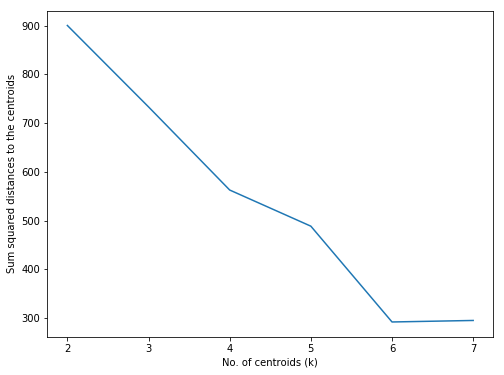

In [92]:
fig, ax = plt.subplots(figsize = (8, 6))
ax.plot(range(2, 8), cost)
ax.set_ylabel('Sum squared distances to the centroids')
ax.set_xlabel('No. of centroids (k)');

## Based on the key hint that the number of attempts should be split equally between the hackers, we could predict that there were two hackers. Although if the elbow plot is given higher weight and no constraint put on the number of hackers, we might conclude that there were five to six hackers